# Intercellular Context Factorization with MOFA

## Background

Here, we will adapt the statistical framework of multi-omics factor analysis ([MOFA](https://www.embopress.org/doi/full/10.15252/msb.20178124)) to obtain intercellular communication programmes - in the form of ligand-receptor interaction scores observed to change across samples. This application of MOFA is inspired by and is in line with the factorization proposed by Tensor-cell2cell [Armingol and Baghdassarian et al., 2022](https://www.nature.com/articles/s41467-022-31369-2) - see existing [tutorial](https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html). 

Such factorization approaches essentially enable us to decipher context-driven intercellular communication by simultaneously accounting for an unlimited number of “contexts” in an untargeted manner.
Similarly to Tensor-cell2cell, this application of MOFA is able to handle cell-cell communication results coming from any experimental design, regardless of its complexity. 

Simply put, we will use LIANA’s output by sample to build a multi-view structure represented by samples and interactions by cell type pairs (views). 
We will then use [MOFA+](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1) to capture the CCC patterns across samples. To do so, we combine liana with the [MuData](https://mudata.readthedocs.io/en/latest/notebooks/quickstart_mudata.html)/[muon](https://link.springer.com/article/10.1186/s13059-021-02577-8) infrastructure.

## Load Packages

mofa, decoupler, omnipath, and marsilea can be installed via pip with the following commands:

```python
pip install decoupler
pip install mofax
pip install muon
pip install omnipath
pip install marsilea
```

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
import mofax as mofa

import decoupler as dc

/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load & Prep Data

As a simple example, we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018](https://www.nature.com/articles/nbt.4042); [GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

This dataset is downloaded from a link on Figshare; preprocessed for [pertpy](https://github.com/theislab/pertpy).

In [2]:
adata = li.testing.datasets.kang_2018()

/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/liana/testing/datasets.py:36: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


In [3]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Define columns of interest from `.obs`

Note that we use cell abbreviations because MOFA will use them as labels for the views.

In [4]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_abbr'

### Basic Preparation

Note that this data has been largely pre-processed & annotated, we refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) and other relevant chapters from the best-practices book for information about pre-processing and annotation steps.

In [5]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

### Showcase the data

... storing 'sample' as categorical


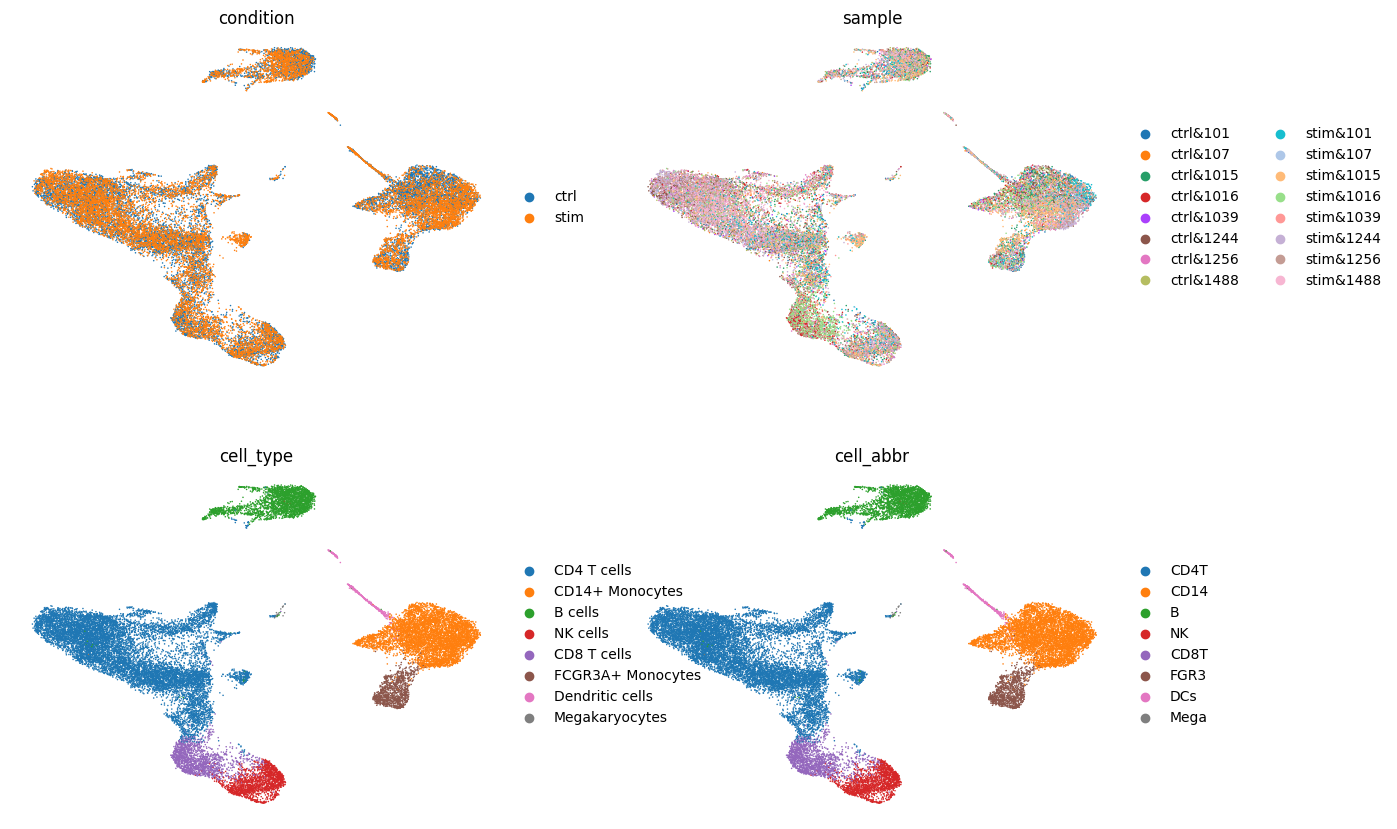

In [6]:
# Show pre-computed UMAP
sc.pl.umap(adata, color=[condition_key, sample_key, 'cell_type', groupby], frameon=False, ncols=2)

## Ligand-Receptor Inference by Sample

Before we decompose the CCC patterns across contexts/samples with `MOFA`, we first need to run `liana` on each sample. To do so, liana provides a utility function called `by_sample` that runs each method in LIANA on each sample within the `AnnData` object, and returns a long-format `pandas.DataFrame` with the results.

In this example, we will use liana's `rank_aggregate` method, which provides a robust rank consensus that combines the predictions of multiple ligand-receptor methods. Nevertheless, any other method can be used.

In [7]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    resource_name='consensus', # NOTE: uses HUMAN gene symbols
    sample_key=sample_key, # sample key by which we which to loop
    expr_prop = 0.1,
    use_raw=False, 
    n_perms=100, # reduce permutations for speed
    return_all_lrs=False, # we don't return all LR values to utilize MOFA's flexible views
    verbose=True, # use 'full' to show all information
    ) 

Now running: ctrl&101:   0%|          | 0/16 [00:00<?, ?it/s]/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:256: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as act

Check results

In [8]:
adata.uns["liana_res"].sort_values("magnitude_rank").head()

,sample,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
5806,ctrl&1039,FGR3,CD14,TIMP1,CD63,2.547695,0.0,5.674415,1.301281,1.767435,0.104337,0.981838,0.014324,0.000002
15798,stim&1015,NK,NK,B2M,KLRD1,2.471536,0.0,2.552514,1.650699,0.789530,0.096218,0.977725,0.032177,0.000002
22885,stim&1256,NK,NK,B2M,KLRD1,2.561136,0.0,2.982985,1.479990,0.931471,0.089038,0.979089,0.032345,0.000003
7899,ctrl&1244,FGR3,CD14,TIMP1,CD63,2.504210,0.0,5.661785,1.703509,2.209408,0.116978,0.985015,0.001211,0.000004
1399,ctrl&107,FGR3,CD14,TIMP1,CD63,2.544711,0.0,5.852476,1.065290,1.678028,0.104096,0.982827,0.008478,0.000004


In [9]:
adata.uns["liana_res"]['source'].unique()

array(['FGR3', 'CD14', 'NK', 'CD8T', 'B', 'DCs', 'CD4T'], dtype=object)

<div class="alert alert-info">

**Note**
    
<h4> by_sample </h4>

We see that in addition to the usual results, we also get `sample` as a column which corresponds to the name of the `sample_key` in the `AnnData` object.

</div>  

Now that we have obtained results by sample, we can use a dotplot by sample to visualize the ligand-receptor interactions. Let's pick arbitrarily the interactions with the highest `magnitude_rank`.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


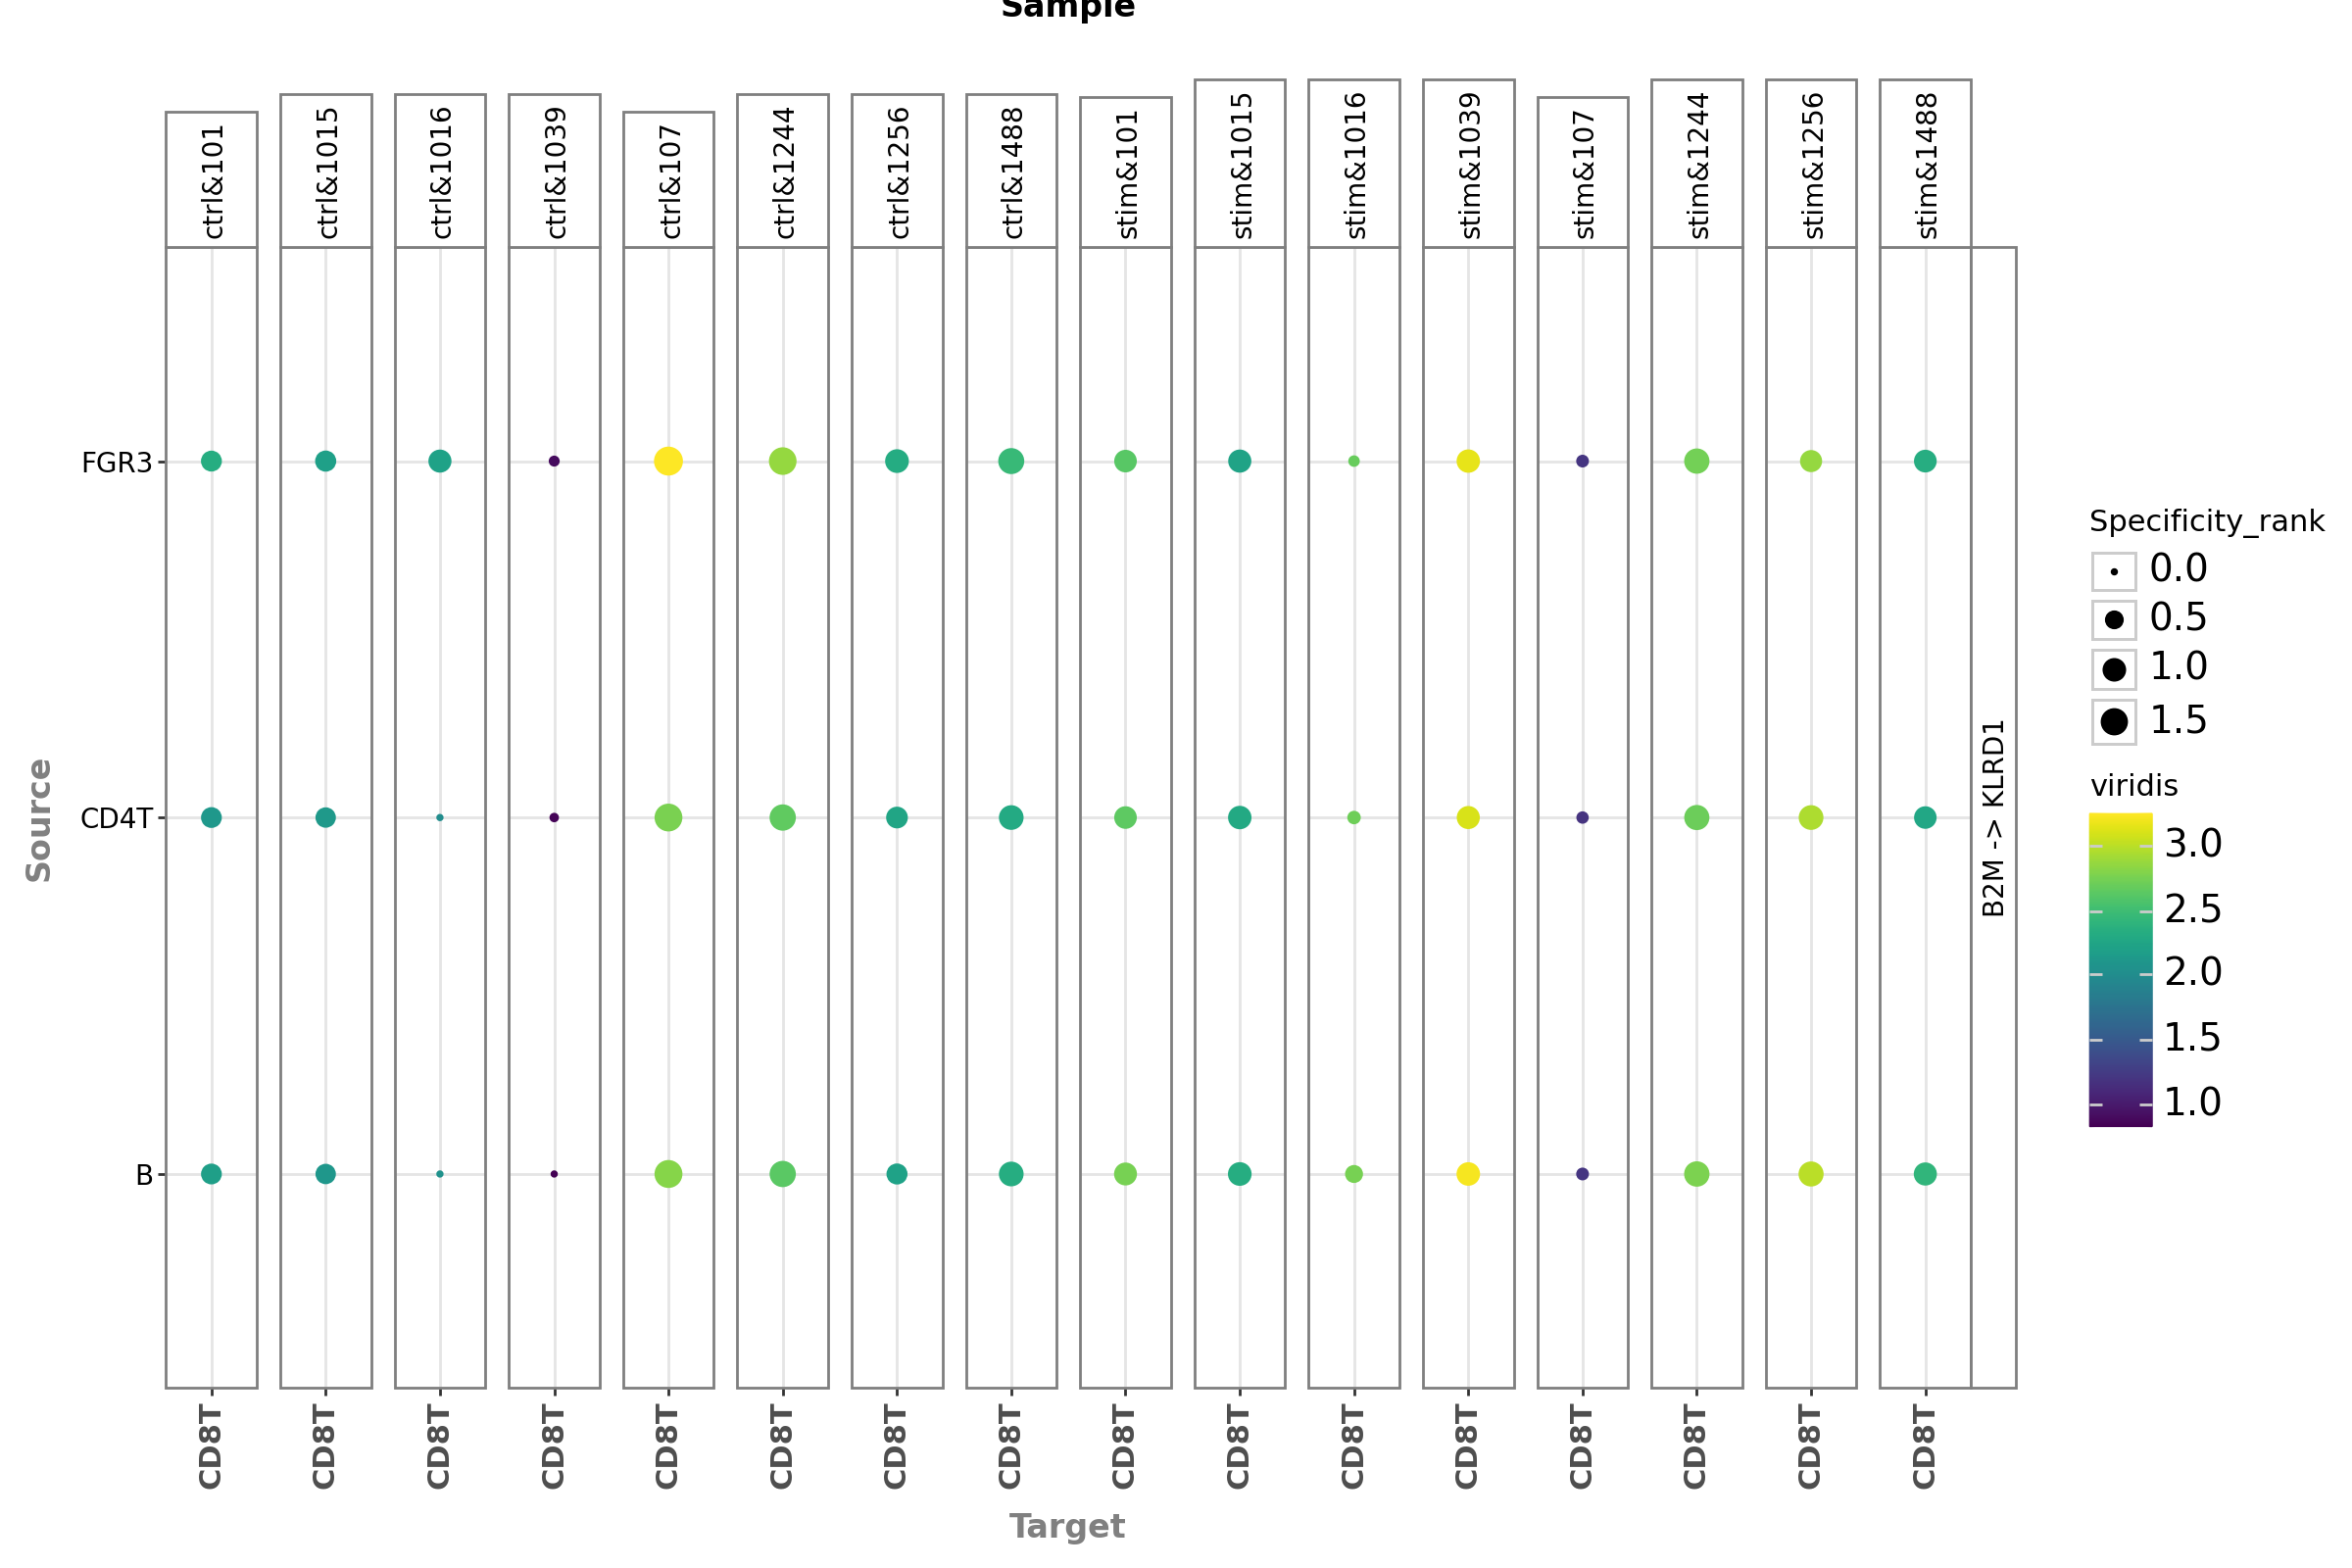

In [10]:
(li.pl.dotplot_by_sample(adata, sample_key=sample_key,
                         colour="magnitude_rank",
                         size="specificity_rank",
                         source_labels=["CD4T", "B", "FGR3"],
                         target_labels=["CD8T", 'DCs', 'CD14'],
                         ligand_complex=["B2M"],
                         inverse_colour=True,
                         inverse_size=True,
                         receptor_complex=["KLRD1", "LILRB2", "CD3D"],
                         figure_size=(12, 8),
                         size_range=(0.5, 5),
                         ) +
    # rotate facet labels
    p9.theme(strip_text=p9.element_text(size=10, colour="black", angle=90))
 )

Even on a small subset interactions and cell types, we can see that interpretation becomes challenging. To overcome this, we can use MOFA to find the variable CCC patterns across contexts/samples.

## Create a Multi-View Structure

Before we can identify the variable CCC patterns across contexts/samples, we need to create a multi-view structure. 
In this case, we will use the `lrs_to_views` function from liana to create a list of views (stored in a MuData object), where each view corresponds to a pair of potentially interacting cell types.
The scores of interactions between cell type pairs represent those inferred with liana, stored by default in `adata.uns['liana_res']`. Here, we will use liana's aggregate 'magnitude_rank'.

In [11]:
mdata = li.multi.lrs_to_views(adata,
                              sample_key=sample_key,
                              score_key='magnitude_rank',
                              obs_keys=['patient', 'condition'], # add those to mdata.obs
                              lr_prop = 0.3, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 20, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 5, # NOTE: minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

  0%|          | 0/43 [00:00<?, ?it/s]

/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/mofatalk/lib/python3.10/site-packages/anndata/_core/anndat

The `lr_fill` parameter controls how we deal with missing interaction scores. The default is `np.nan` and in that case the scores would be imputed by MOFA.

Here, we fill the missing ligand-receptors with 0s because the ligand-receptor interaction missing here, i.e. those when `return_all_lrs=False`, are such which are not expressed above a certain proportion of cells per cell type (that is controlled via `expr_prop` when running liana).

Given the assumption that the ligand-receptor interactions occur at the across cell type level, we could thus assume that the genes that are not present in a sufficient proportion of cells are unlikely to be involved in interactions that are relevant to the cell type as a whole.

<div class="alert alert-info">

**Note**
    
<h5> View Representation </h5>

MOFA supports the flexible representation of views, where each view can represent a different type of features (e.g. genes, proteins, metabolites, etc.). In this case, we simply allow for different ligand-receptor to be used in each cell type pair (view).

</div>  

In [12]:
mdata

MuData object with n_obs × n_vars = 16 × 1786
  obs:	'patient', 'condition'
  36 modalities
    FGR3&CD14:	16 x 76
    FGR3&DCs:	16 x 87
    CD14&CD14:	16 x 81
    FGR3&NK:	16 x 39
    DCs&NK:	16 x 44
    FGR3&FGR3:	16 x 79
    DCs&CD14:	16 x 79
    CD14&NK:	16 x 43
    NK&CD8T:	14 x 33
    CD14&DCs:	16 x 86
    FGR3&CD8T:	16 x 46
    CD8T&CD8T:	12 x 29
    DCs&DCs:	16 x 89
    CD14&FGR3:	16 x 79
    DCs&FGR3:	16 x 82
    B&CD8T:	14 x 37
    DCs&CD8T:	16 x 52
    CD4T&CD8T:	11 x 27
    CD14&CD8T:	16 x 50
    FGR3&CD4T:	12 x 34
    DCs&CD4T:	13 x 37
    CD14&CD4T:	11 x 32
    CD8T&CD14:	16 x 35
    NK&CD14:	15 x 45
    B&CD14:	14 x 42
    NK&FGR3:	16 x 44
    CD8T&FGR3:	16 x 36
    CD4T&CD14:	15 x 38
    B&FGR3:	16 x 39
    CD4T&FGR3:	16 x 37
    NK&DCs:	14 x 47
    B&DCs:	12 x 50
    CD4T&DCs:	11 x 37
    CD8T&DCs:	12 x 38
    NK&NK:	7 x 28
    B&NK:	7 x 29

## Fitting a MOFA model

Now that the putative ligand-receptor interactions across samples aretransformed into a multi-view representation, we can use MOFA to run an intercellular communication factor analysis.

We will attempt to capture the variability across samples and the different cell-type pairs by reducing the data into a number of factors, where each factor captures the coordinated communication events across the cell types.

In [13]:
mu.tl.mofa(mdata, 
           use_obs='union',
           convergence_mode='medium',
           outfile='models/mofatalk.h5ad',
           n_factors=4,
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='FGR3&CD14' group='group1' with N=16 samples and D=76 features...
Loaded view='FGR3&DCs' group='group1' with N=16 samples and D=87 features...
Loaded view='CD14&CD14' group='group1' with N=16 samples and D=81 features...
Loaded view='FGR3&NK' group='group1' with N=16 samples and D=39 features...
Loaded view='DCs&NK' group='group1' with N=16 samples and D=44 features.


Converged!



#######################
## Training finished ##
#######################


Saving model in models/mofatalk.h5ad...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].


## Exploring the MOFA model

For convenience, we provide simple getter function to access the model parameters, in addition to those available via the [MuData API](https://mudata.readthedocs.io/en/latest/api/index.html) & the MOFA model itself.

### Explore Metadata Associations to the Factor Scores

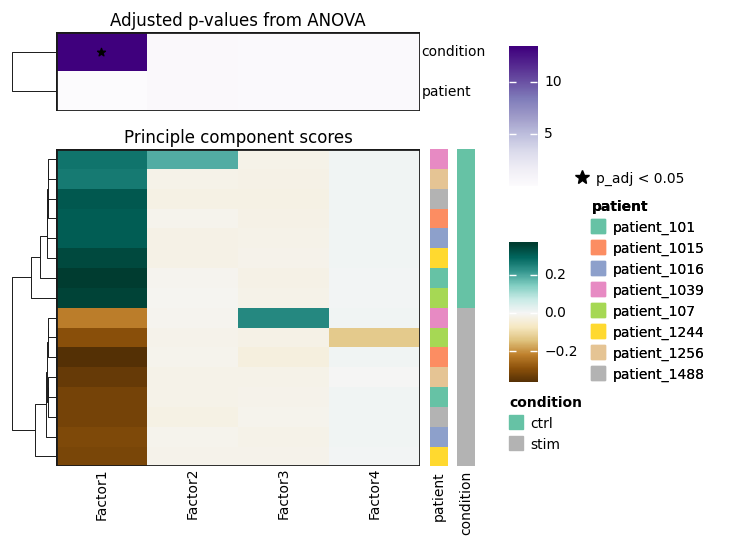

In [40]:
dc.get_metadata_associations(
    mdata,
    obs_keys = ['patient', 'condition'],  # Metadata columns to associate to PCs
    obsm_key='X_mofa',  # Where the PCs are stored
    uns_key='mofa_anova',  # Where the results are stored
    inplace=True,
)

dc.plot_associations(
    mdata,
    uns_key='mofa_anova',  # Summary statistics from the anova tests
    obsm_key='X_mofa',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['patient', 'condition'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

In [41]:
# obtain the factor scores as a dataframe
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=['patient', 'condition'])
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,patient,condition
0,ctrl&101,0.367283,-0.006222,-0.017936,0.008424,patient_101,ctrl
1,ctrl&1015,0.308093,-0.010797,-0.017321,0.009309,patient_1015,ctrl
2,ctrl&1016,0.309456,-0.018315,-0.015810,0.009731,patient_1016,ctrl
3,ctrl&1039,0.272983,0.191819,-0.016298,0.010114,patient_1039,ctrl
4,ctrl&107,0.354449,-0.003768,-0.014635,0.008547,patient_107,ctrl


Let's check if any of the factors are associated with the sample condition:

In [42]:
 # we use a paired t-test as the samples are paired
from scipy.stats import ttest_rel

In [43]:
# split in control and stimulated
group1 = factor_scores[factor_scores['condition']=='ctrl']
group2 = factor_scores[factor_scores['condition']=='stim']

# get all columns that contain factor & loop
factors = [col for col in factor_scores.columns if 'Factor' in col]
for factor in factors:
    print(ttest_rel(group1[factor], group2[factor]))
    

TtestResult(statistic=29.66841626796324, pvalue=1.2735360132976416e-08, df=7)
TtestResult(statistic=1.038929444964987, pvalue=0.3333866856758169, df=7)
TtestResult(statistic=-1.0138154380659183, pvalue=0.3444240899287761, df=7)
TtestResult(statistic=1.096074729858932, pvalue=0.30931685700602035, df=7)


We can see that the first factor is associated with the sample condition, let's plot the factor scores:

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


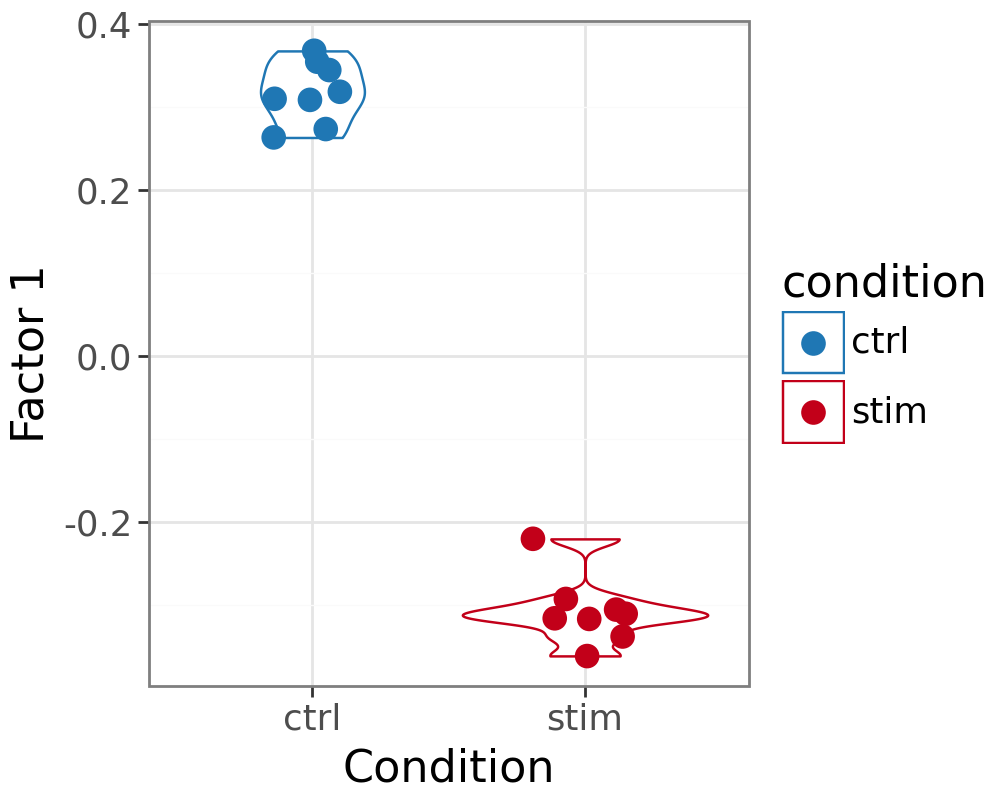

In [44]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw(base_size=16) +
 p9.theme(figure_size=(5, 4)) +
 p9.scale_colour_manual(values=['#1f77b4', '#c20019']) +
 p9.labs(x='Condition', y='Factor 1')
 )

#### Explore Ligand-Receptor loadings

Now that we have identified a factor that is associated with the sample condition, we can check the ligand-receptor loadings with the highest loadings:

In [45]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4
1036,HLA-DRA,LAG3,DCs,CD8T,-3.329328,7.220581,0.047571,0.140793
175,CCL8,CCR1,CD14,CD14,-2.348269,-0.076234,0.009217,0.002336
237,TIMP1,CD63,CD14,CD14,2.315588,0.421881,-0.003823,0.002497
1037,HLA-DRB1,LAG3,DCs,CD8T,-2.089382,6.373016,-0.032115,0.031161
167,CCL2,CCR1,CD14,CD14,-2.035508,-0.067302,-0.000216,-0.093410


In [46]:
# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


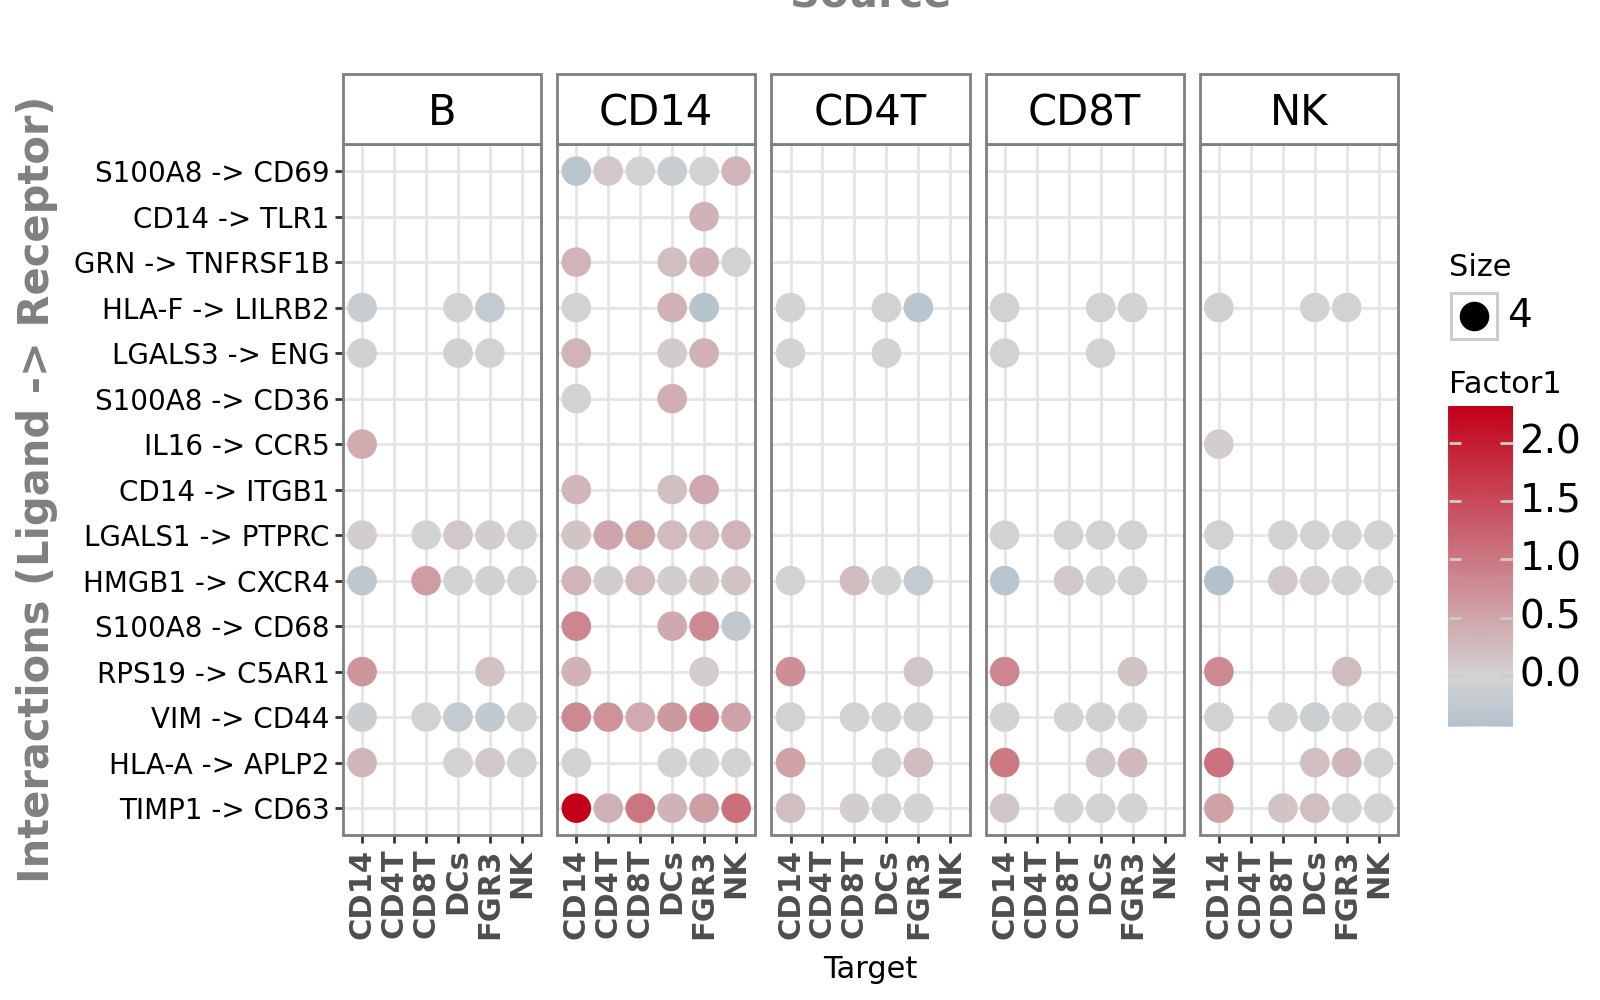

In [47]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour='Factor1', 
                        orderby='Factor1',
                        top_n=15,
                        source_labels=['NK', 'B', 'CD4T', 'CD8T', 'CD14'],
                        orderby_ascending=False,
                        size_range=(0.1, 5),
                        figure_size=(8, 5)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019')

Here, we can see that certain interactions from Factor 1 have high positive loadings. These are interactions that are associated with the samples with high factor scores (i.e. the stimulated samples with high scores in Factor 1).

### Explore the model

Finally, we can also explore the MOFA model itself and we will specifically check the variance explained by each pair of cell types.

In [48]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 16
Features: 1786
Groups: group1 (16)
Views: B&CD14 (42), B&CD8T (37), B&DCs (50), B&FGR3 (39), B&NK (29), CD14&CD14 (81), CD14&CD4T (32), CD14&CD8T (50), CD14&DCs (86), CD14&FGR3 (79), CD14&NK (43), CD4T&CD14 (38), CD4T&CD8T (27), CD4T&DCs (37), CD4T&FGR3 (37), CD8T&CD14 (35), CD8T&CD8T (29), CD8T&DCs (38), CD8T&FGR3 (36), DCs&CD14 (79), DCs&CD4T (37), DCs&CD8T (52), DCs&DCs (89), DCs&FGR3 (82), DCs&NK (44), FGR3&CD14 (76), FGR3&CD4T (34), FGR3&CD8T (46), FGR3&DCs (87), FGR3&FGR3 (79), FGR3&NK (39), NK&CD14 (45), NK&CD8T (33), NK&DCs (47), NK&FGR3 (44), NK&NK (28)
Factors: 4
Expectations: W, Z

In [49]:
# get variance explained by view and factor
rsq = model.get_r2()
factor1_rsq = rsq[rsq['Factor']=='Factor1']
# separate view column
factor1_rsq[['source', 'target']] = factor1_rsq['View'].str.split(pat='&', n=1, expand=True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


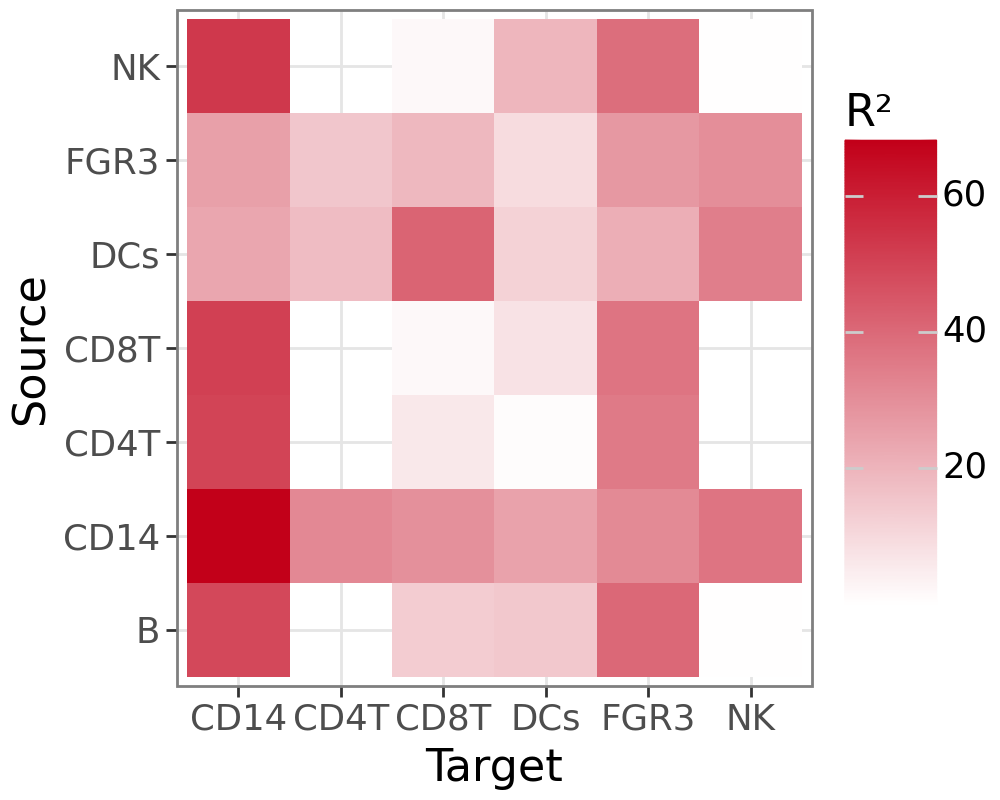

In [50]:
(p9.ggplot(factor1_rsq.reset_index()) + 
 p9.aes(x='target', y='source') + 
 p9.geom_tile(p9.aes(fill='R2')) + 
 p9.scale_fill_gradient2(low='white', high='#c20019') +
 p9.theme_bw(base_size=16) +
 p9.theme(figure_size=(5, 4)) +
 p9.labs(x='Target', y='Source', fill='R²')
 )

Here, we can see that views that include CD14+ Monocytes have the highest variance explained both as source and as target of intercellular communication events. In particular, we see that putative autocrine interactions that occur between CD14+ Monocytes are highly explained by Factor 1.

## Pathway enrichment

Let's also perform an enrichment analysis on the ligand-receptor interactions that are associated with the factor of interest. We will use [decoupler](https://github.com/saezlab/decoupler-py) with pathway genesets from [PROGENy](https://github.com/saezlab/progeny) to look for enrichments across the cell type pairs (views).

In [51]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [25]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
60,JAK-STAT,LGALS9^PTPRC,1.307807
844,JAK-STAT,LGALS9^CD47,2.054778
1130,Trail,LGALS9^PTPRK,0.937003
1432,JAK-STAT,LGALS9^HAVCR2,1.487678
1779,EGFR,DLL1^NOTCH1,-1.000584


In [26]:
lr_loadings =  li.ut.get_variable_loadings(mdata,
                                           varm_key='LFs',
                                           view_sep=':',
                                           )
lr_loadings.set_index('variable', inplace=True)
# pivot views to wide
lr_loadings = lr_loadings.pivot(columns='view', values='Factor1')
# replace NaN with 0
lr_loadings.replace(np.nan, 0, inplace=True)
lr_loadings.head()


view,B&CD14,B&CD8T,B&DCs,B&FGR3,B&NK,CD14&CD14,CD14&CD4T,CD14&CD8T,CD14&DCs,CD14&FGR3,...,FGR3&CD4T,FGR3&CD8T,FGR3&DCs,FGR3&FGR3,FGR3&NK,NK&CD14,NK&CD8T,NK&DCs,NK&FGR3,NK&NK
variable,,,,,,,,,,,,,,,,,,,,,
ADAM10^AXL,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.000000,-0.082392,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ADAM10^CD44,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.115942,-0.027238,-0.038844,0.007019,0.001741,0.0,0.0,0.0,0.0,0.0
ADAM17^RHBDF2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.000000,-0.149146,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ADAM28^ITGA4,0.0,0.0,0.0,-0.279046,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ADM^CALCRL,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.26092,0.0,...,0.000000,0.000000,-0.035988,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [27]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(), lr_progeny,
                              source="source", target="interaction",
                              use_raw=False, min_n=5)
# pivot columns to long
estimate = (estimate.
            melt(ignore_index=False, value_name='estimate', var_name='pathway').
            reset_index().
            rename(columns={'index':'view'})
            )

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


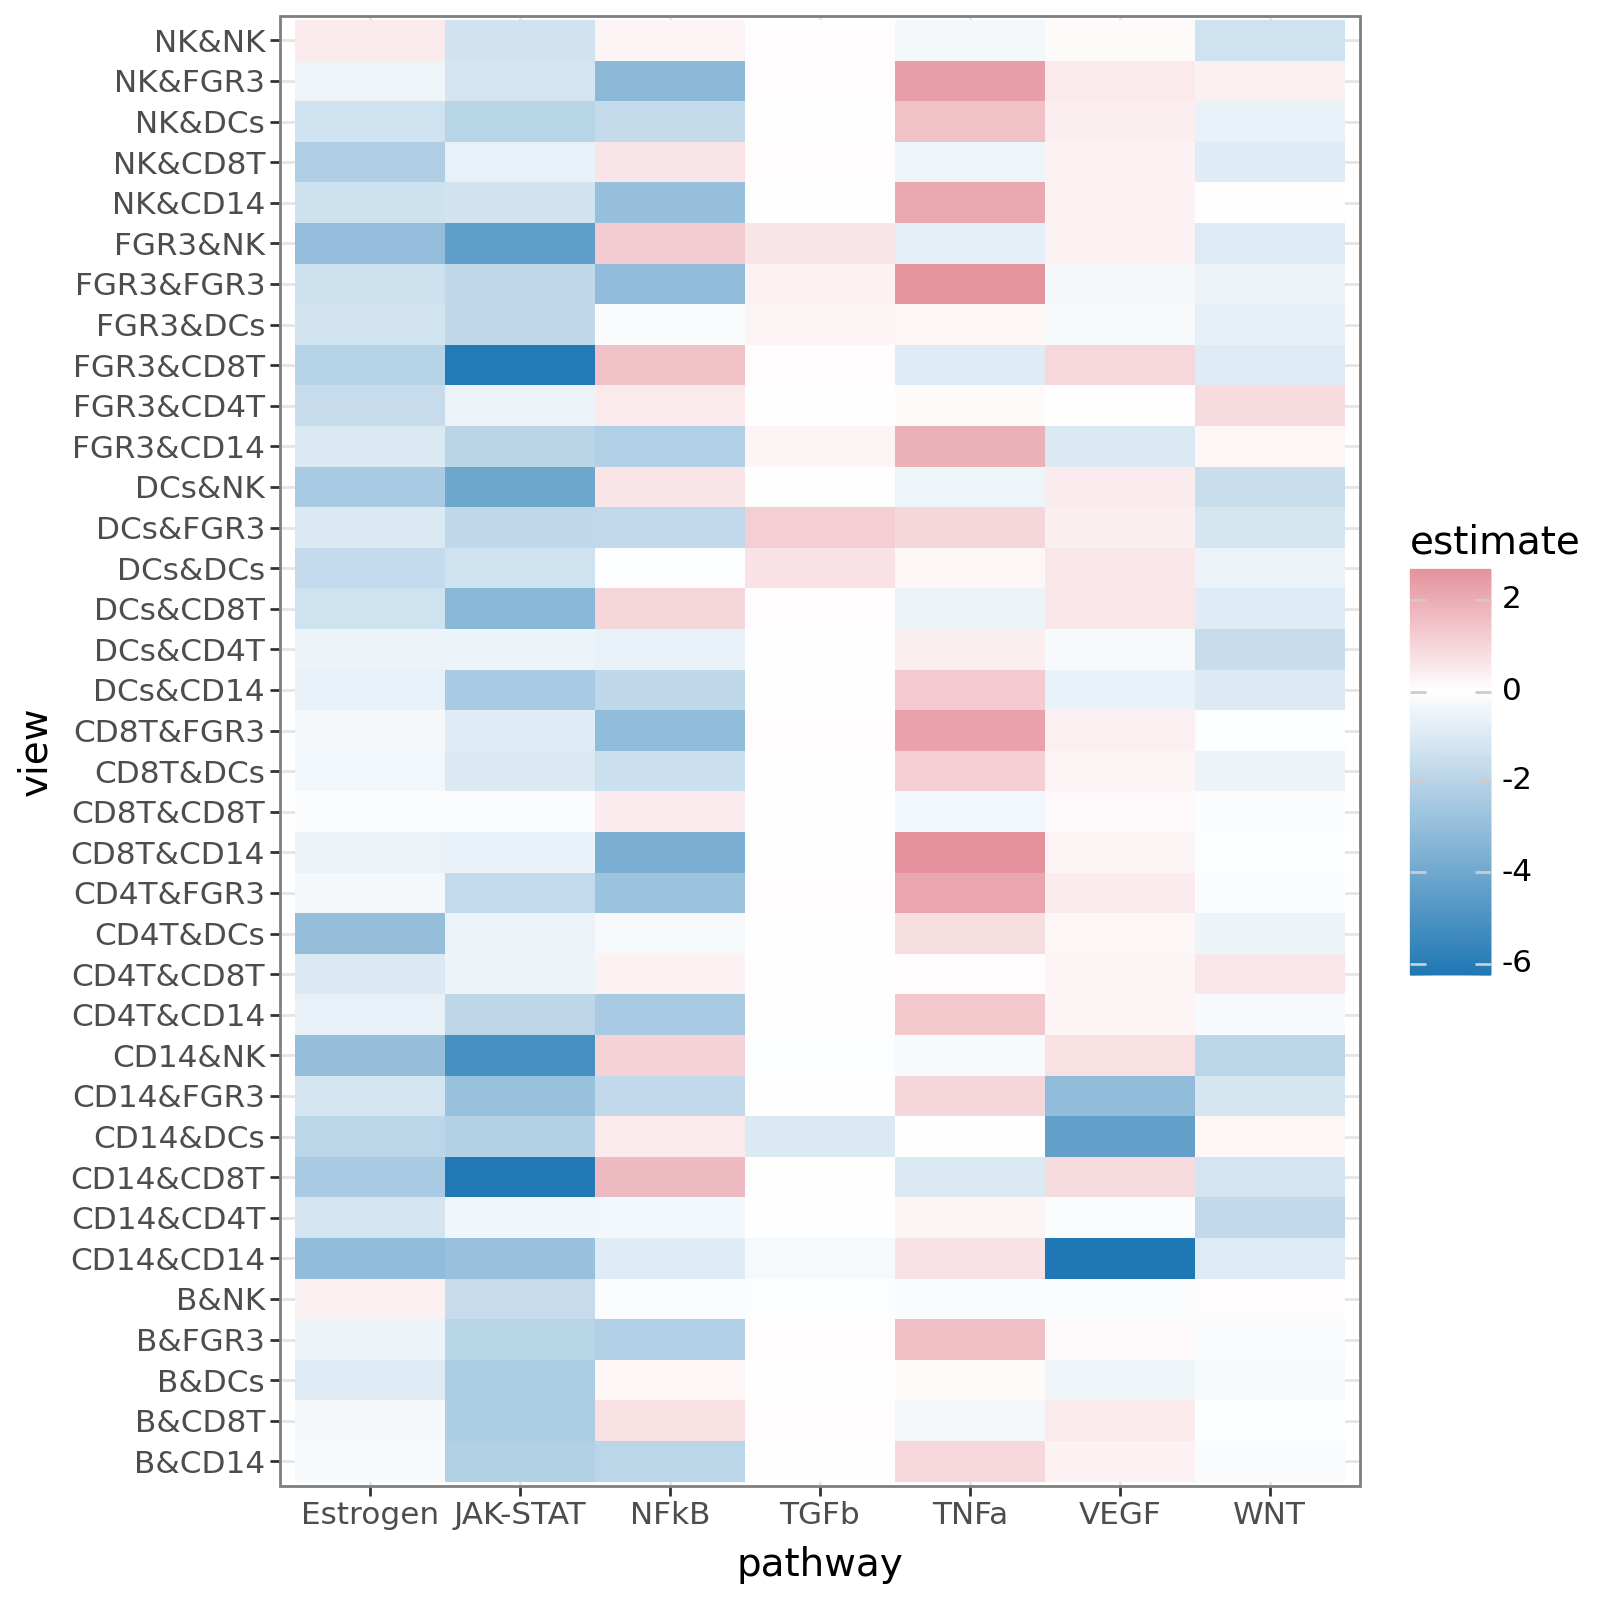

In [28]:
## p9 tile plot
(p9.ggplot(estimate) + 
 p9.aes(x='pathway', y='view') +
 p9.geom_tile(p9.aes(fill='estimate')) +
 p9.scale_fill_gradient2(low='#1f77b4', high='#c20019') +
 p9.theme_bw(base_size=14) +
 p9.theme(figure_size=(8, 8))
)

<div class="alert alert-warning">
  Some of these interactions are not expressed in the data, so we use the `lr_fill` parameter to fill them with 0s.
  This is a rather arbitrary choice, but it is a simple way to deal with missing values. Additionally, since we the views (cell type pairs) are rather sparse, it's possible that the enrichment analysis will not be very informative. Be sure to check the results carefully.
</div>

## Outlook & Further Analysis

This tutorial is just a short introduction of the use of MOFA, we thus refer the users to the available [MOFA](https://biofam.github.io/MOFA2/tutorials.html) & [muon tutorials](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/index.html) for more applications & details.

Similary, consider citing both muon & MOFA+ if you use them in your work!

In [29]:
model.close()